In [1]:
%matplotlib notebook
%matplotlib inline

import os
import time
import datetime as dt
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import pandas
import pandas_datareader
import stock_data_preprocessing as sdp
import featureEng as fe

In [2]:
#load data
start = dt.datetime(1995,1,1)
end   = dt.date.today()
data = pandas_datareader.data.DataReader('ASTC','yahoo',start,end)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1995-12-21,120.0,125.0,120.0,120.0,120.0,70200.0
1995-12-22,120.0,122.5,120.0,120.0,120.0,41600.0
1995-12-26,120.0,122.5,120.0,120.0,120.0,1500.0
1995-12-27,122.5,122.5,120.0,120.0,120.0,6600.0
1995-12-28,120.0,122.5,120.0,120.0,120.0,22500.0


In [3]:
data = fe.derivative(data, fill_na = False)
data.head()

,Open,High,Low,Close,Adj Close,Volume,d1close,d2close,d1vol,d2vol
Date,,,,,,,,,,
1995-12-21,120.0,125.0,120.0,120.0,120.0,70200.0,NaN,NaN,NaN,NaN
1995-12-22,120.0,122.5,120.0,120.0,120.0,41600.0,0.0,NaN,-28600.0,NaN
1995-12-26,120.0,122.5,120.0,120.0,120.0,1500.0,0.0,0.0,-40100.0,-11500.0
1995-12-27,122.5,122.5,120.0,120.0,120.0,6600.0,0.0,0.0,5100.0,45200.0
1995-12-28,120.0,122.5,120.0,120.0,120.0,22500.0,0.0,0.0,15900.0,10800.0


In [4]:
# fill NA with zero (from derivatives)
data = data.fillna(0)

In [7]:
max(data['Adj Close'])

153.75

# Normalise and Prepozess the data like a boss^12

In [3]:
#normalise data
data_n = stock_data_preprocessing.normalize_stock_data(data)
data_n.head()

,Ordinal/1e6,Weekday,Adj Volume,Adj Close,Adj Open,Adj High,Adj Low,Normalised Volume,Normalised Close,Normalised Open,Normalised High,Normalised Low
Date,,,,,,,,,,,,
1995-12-21,0.728648,3.0,0.006483,1.0,1.000000,1.041667,1.0,0.000000,0.0,0.000000,0.000000,0.0
1995-12-22,0.728649,4.0,0.003842,1.0,1.000000,1.020833,1.0,-0.996158,0.0,0.000000,0.020833,0.0
1995-12-26,0.728653,1.0,0.000139,1.0,1.000000,1.020833,1.0,-0.999861,0.0,0.000000,0.020833,0.0
1995-12-27,0.728654,2.0,0.000609,1.0,1.020833,1.020833,1.0,-0.999391,0.0,0.020833,0.020833,0.0
1995-12-28,0.728655,3.0,0.002078,1.0,1.000000,1.020833,1.0,-0.997922,0.0,0.000000,0.020833,0.0


# 1,2,3 Plot Line!

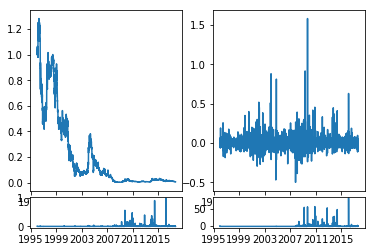

In [4]:
stock_data_preprocessing.stock_plot(data_n)

# Pickup the Data

In [54]:
# training data
prediction_time = 1 #day
testdatasize = 450
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

x_train = data_n[0:-prediction_time-testdatacut].as_matrix()
y_train = data_n[prediction_time:-testdatacut  ]['Normalised Close'].as_matrix()

# test data
x_test = data_n[0-testdatacut:-prediction_time].as_matrix()
y_test = data_n[prediction_time-testdatacut:  ]['Normalised Close'].as_matrix()



In [55]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (4962, 12)
y_train (4962,)
x_test (500, 12)
y_test (500,)


# unroll it

In [56]:
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)


x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]


print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (4912, 50, 12)
y_train (4912,)
x_test (450, 50, 12)
y_test (450,)


# Model Building

In [13]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import lstm, time #helper libraries

Using TensorFlow backend.


In [61]:
x_train.shape

(4912, 50, 12)

In [15]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_shape=(None, x_train.shape[-1]),
    units =50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.012496232986450195


In [16]:
#Step 3 Train the model
model.fit(
    x_train,
    y_train,
    batch_size=3028,
    epochs=350,
    validation_split=0.05)

Train on 4666 samples, validate on 246 samples
Epoch 1/350
4666/4666 [==============================] - 8s - loss: 0.1940 - val_loss: 0.0044
Epoch 2/350
4666/4666 [==============================] - 7s - loss: 0.0144 - val_loss: 0.0038
Epoch 3/350
4666/4666 [==============================] - 7s - loss: 0.0140 - val_loss: 0.0039
Epoch 4/350
4666/4666 [==============================] - 7s - loss: 0.0139 - val_loss: 0.0035
Epoch 5/350
4666/4666 [==============================] - 7s - loss: 0.0131 - val_loss: 0.0033
Epoch 6/350
4666/4666 [==============================] - 7s - loss: 0.0123 - val_loss: 0.0029
Epoch 7/350
4666/4666 [==============================] - 7s - loss: 0.0118 - val_loss: 0.0027
Epoch 8/350
4666/4666 [==============================] - 7s - loss: 0.0117 - val_loss: 0.0024
Epoch 9/350
4666/4666 [==============================] - 7s - loss: 0.0111 - val_loss: 0.0024
Epoch 10/350
4666/4666 [==============================] - 7s - loss: 0.0113 - val_loss: 0.0026
Epoch 11/350

4666/4666 [==============================] - 7s - loss: 0.0047 - val_loss: 0.0012
Epoch 172/350
4666/4666 [==============================] - 7s - loss: 0.0046 - val_loss: 0.0012
Epoch 173/350
4666/4666 [==============================] - 7s - loss: 0.0047 - val_loss: 0.0012
Epoch 174/350
4666/4666 [==============================] - 7s - loss: 0.0046 - val_loss: 0.0012
Epoch 175/350
4666/4666 [==============================] - 7s - loss: 0.0046 - val_loss: 0.0012
Epoch 176/350
4666/4666 [==============================] - 7s - loss: 0.0046 - val_loss: 0.0012
Epoch 177/350
4666/4666 [==============================] - 7s - loss: 0.0047 - val_loss: 0.0012
Epoch 178/350
4666/4666 [==============================] - 7s - loss: 0.0046 - val_loss: 0.0013
Epoch 179/350
4666/4666 [==============================] - 7s - loss: 0.0046 - val_loss: 0.0012
Epoch 180/350
4666/4666 [==============================] - 7s - loss: 0.0047 - val_loss: 0.0013
Epoch 181/350
4666/4666 [=============================

4666/4666 [==============================] - 7s - loss: 0.0039 - val_loss: 0.0013
Epoch 342/350
4666/4666 [==============================] - 7s - loss: 0.0036 - val_loss: 0.0013
Epoch 343/350
4666/4666 [==============================] - 8s - loss: 0.0035 - val_loss: 0.0016
Epoch 344/350
4666/4666 [==============================] - 7s - loss: 0.0035 - val_loss: 0.0014
Epoch 345/350
4666/4666 [==============================] - 8s - loss: 0.0035 - val_loss: 0.0014
Epoch 346/350
4666/4666 [==============================] - 7s - loss: 0.0035 - val_loss: 0.0019
Epoch 347/350
4666/4666 [==============================] - 7s - loss: 0.0036 - val_loss: 0.0014
Epoch 348/350
4666/4666 [==============================] - 7s - loss: 0.0034 - val_loss: 0.0014
Epoch 349/350
4666/4666 [==============================] - 7s - loss: 0.0035 - val_loss: 0.0014
Epoch 350/350
4666/4666 [==============================] - 7s - loss: 0.0034 - val_loss: 0.0014


In [19]:
model.save('lstm_astc.h5')

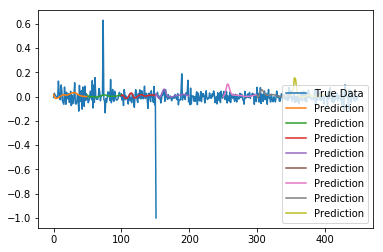

In [18]:
#Step 4 - Plot the predictions!
predictions = lstm.predict_sequences_multiple(model, x_test, 50, 50)
lstm.plot_results_multiple(predictions, y_test, 50)

In [14]:
predictions = lstm.predict_point_by_point(model, x_test)
lstm.plot_results_multiple(predictions, y_test, 50)

NameError: name 'lstm' is not defined